In [221]:
from PIL import Image
from matplotlib import pyplot as plt
from scipy.misc import imresize
from imageio import imwrite
from sklearn.neighbors import KNeighborsClassifier as KNN
from IPython.core.display import display, HTML
import face_recognition_models as frm
import face_recognition as fr
import pandas as pd
import numpy as np
import threading
import queue
import glob
import cv2
import os

%matplotlib inline
display(HTML("<style>.container { width:70% !important; }</style>"))

In [220]:
def resize_img(img, dims=(900,900)):
    h,w = img.shape[:2]
    buffer_h = int(np.round((h - dims[0] ) / 2.0))
    buffer_w = int(np.round((w - dims[1]) / 2.0))
    resized_img = img[buffer_h:h - buffer_h, buffer_w:w - buffer_w, :][:dims[0],:dims[1],:]
    if not resized_img.shape[:2] == dims:
        print('\t', resized_img.shape)
        print('\t', buffer_h, buffer_w)
    return resized_img

In [222]:
def calibrate_fisheye():
    CHECKERBOARD = (6, 9)
    subpix_criteria = (cv2.TERM_CRITERIA_EPS +
                       cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC + \
        cv2.fisheye.CALIB_CHECK_COND+cv2.fisheye.CALIB_FIX_SKEW
    objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
    objp[0, :, :2] = np.mgrid[0:CHECKERBOARD[0],
                              0:CHECKERBOARD[1]].T.reshape(-1, 2)

    _img_shape = None
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    images = glob.glob('calibration/*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        img = resize_img(img=img)
        if _img_shape == None:
            _img_shape = img.shape[:2]
        else:
            assert _img_shape == img.shape[:2], "All images must share the same size."
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(
            gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            cv2.cornerSubPix(gray, corners, (3, 3), (-1, -1), subpix_criteria)
            imgpoints.append(corners)

    N_OK = len(objpoints)
    K = np.zeros((3, 3))
    D = np.zeros((4, 1))
    rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
    tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for i in range(N_OK)]
    rms, _, _, _, _ = \
        cv2.fisheye.calibrate(
            objpoints,
            imgpoints,
            gray.shape[::-1],
            K,
            D,
            rvecs,
            tvecs,
            calibration_flags,
            (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
        )
    print("Found " + str(N_OK) + " valid images for calibration")
    print("DIM=" + str(_img_shape[::-1]))
    print("K=np.array(" + str(K.tolist()) + ")")
    print("D=np.array(" + str(D.tolist()) + ")")

    return K, D

In [240]:
def undistort(img_path, K, D):
    img = cv2.imread(img_path)
    img = resize_img(img=img)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (900,900), cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    return undistorted_img

In [241]:
def threads(num_threads, data, cb_run, *args, **kwargs):
    """
    Threads any function with any data with as many threads as you want (be careful)

    param num_threads: How many threads you want to Run
    type num_threads: int
    param data: The data that you want to parse through
    type data: list
    param cb_run: the function you want to use to parse the data
    type cb_run: function
    """
    task_list = []
    Q = queue.Queue()
    def _thread_run():
        while True:
            proc = Q.get()
            try:
                task_list.append(cb_run(proc, *args, **kwargs))
            except Exception:
                pass
            Q.task_done()

    for i in range(num_threads):
        th = threading.Thread(target=_thread_run)
        th.daemon = True
        th.start()

    for item in data:
        Q.put(item)
    Q.join()
    
    return task_list

In [242]:
def get_list_dir_contents(path):
    dir_contents = glob.glob(os.path.join(path, '*'))
    return dir_contents

In [243]:
def make_folder(fn):
    """
    Creates a folder fn if it doesn't exist
    """
    if os.path.exists(fn):
        print('found existing directory:\t', fn)
    else:
        print('created folder:\t', fn)
        os.makedirs(fn)

In [244]:
def make_nested_folders(folder_structure=None):
    """
    folder_structure (dict):  {'outer_folder1': ['subfolders', 'of', 'outer_folder1']}
        Creates (in current dir):
            outer_folder1/
                      subfolders/
                      of/
                      outer_folder1/
    """
    if folder_structure is not None:
        for parent_folder, children in folder_structure.items():
            make_folder(parent_folder)
            for child_folder in children:
                make_folder(parent_folder + '/' + child_folder)

In [245]:
def prepare_env(class_names=['max', 'caleb', 'drew', 'arshia', 'corbet']):
    make_nested_folders({
        ENVIRONMENT_NAME: [DATA_FOLDER_NAME, MODEL_FOLDER_NAME]
    })
    for each_person in class_names:
        person_folder = ENVIRONMENT_NAME + '/' + DATA_FOLDER_NAME + '/' + each_person
        make_nested_folders({person_folder: ['imgs', 'processed_imgs', 'face_encodings']})

In [246]:
def robust_bounding_boxes(img, model_type='hog'):
    """
    Operates under the assumption that img likely has only 1 face
    """
    attempts = 0
    bounding_boxes = fr.face_locations(img)
    downsample_pcts = [x**2 for x in np.linspace( 1, 1.000000000000001, 1)]
    temp_best = bounding_boxes, img
    while attempts < 1:
        lower_res_img = imresize(img, downsample_pcts[attempts])
        bounding_boxes = fr.face_locations(lower_res_img, number_of_times_to_upsample=0, model=model_type)
        if len(bounding_boxes) == 1:
            return lower_res_img, bounding_boxes[0]
        elif len(bounding_boxes) > 1:
            temp_best = lower_res_img, bounding_boxes[0]
        attempts += 1
    if len(temp_best[0]) > 1:
        print('UNEXPECTED: Found', len(temp_best[0]), 'faces.\n----> Only returning 1 bounding box')
        return temp_best
    else:
        print('No faces found')
        return img, None

In [247]:
def process_persons_imgs(name='max'): # env
    all_persons_img_paths = get_list_dir_contents(ENVIRONMENT_NAME + '/' + DATA_FOLDER_NAME + '/' + name + '/imgs') # fix
    data = threads(8, all_persons_img_paths, process_img, name=name)
    return data

In [248]:
def process_img(img_path, name='max'):
    img = fr.load_image_file(img_path)
    
    resized_img, bounding_box = robust_bounding_boxes(img)
    if '\\' in img_path: # fix
        outpath = 'processed_imgs/PR_'.join(img_path.split('imgs\\'))
    else:
        outpath = 'processed_imgs/PR_'.join(img_path.split('imgs/'))
    # insert further preprocessing here (synthetic data augmentation, etc)
    if bounding_box != None:
        imwrite(outpath, resized_img)
        encoding = fr.face_encodings(resized_img, known_face_locations=[bounding_box], num_jitters=1)[0]
        return {'t': bounding_box[0], 'b': bounding_box[2], 'l': bounding_box[3], 'r': bounding_box[1], 'outpath': outpath, 'encoding': encoding, 'name': name}
    print('no faces detected:\t', img_path)
    return {'t': None, 'b': None, 'l': None, 'r': None, 'outpath': None, 'encoding': None, 'name': name}

In [249]:
K, D = calibrate_fisheye()

Found 8 valid images for calibration
DIM=(900, 900)
K=np.array([[727.9060820145388, 0.0, 502.88362268584706], [0.0, 733.2663478208146, 399.84572706293386], [0.0, 0.0, 1.0]])
D=np.array([[-0.456394865516854], [-1.8144504087392264], [16.993996535084175], [-43.30015122846782]])


In [233]:
ENVIRONMENT_NAME = 'default_env'
DATA_FOLDER_NAME = 'data'
MODEL_FOLDER_NAME = 'models'
CLASS_NAMES = ['max', 'caleb', 'arshia', 'drew', 'corbet']
prepare_env(CLASS_NAMES)

found existing directory:	 default_env
found existing directory:	 default_env/data
found existing directory:	 default_env/models
found existing directory:	 default_env/data/max
found existing directory:	 default_env/data/max/imgs
found existing directory:	 default_env/data/max/processed_imgs
found existing directory:	 default_env/data/max/face_encodings
found existing directory:	 default_env/data/caleb
found existing directory:	 default_env/data/caleb/imgs
found existing directory:	 default_env/data/caleb/processed_imgs
found existing directory:	 default_env/data/caleb/face_encodings
found existing directory:	 default_env/data/arshia
found existing directory:	 default_env/data/arshia/imgs
found existing directory:	 default_env/data/arshia/processed_imgs
found existing directory:	 default_env/data/arshia/face_encodings
found existing directory:	 default_env/data/drew
found existing directory:	 default_env/data/drew/imgs
found existing directory:	 default_env/data/drew/processed_imgs
fou

In [234]:
all_data = []
for name in CLASS_NAMES:
    person_data = process_persons_imgs(name=name)
    person_df = pd.DataFrame(person_data)
    person_df.to_csv(ENVIRONMENT_NAME + '/' + DATA_FOLDER_NAME + '/' + name + '/face_encodings/encodings.csv', index=False)
    print('Done with', name)
    all_data.extend(person_data)
all_df = pd.DataFrame(all_data)

c:\users\the-slick\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


Done with max
No faces found
no faces detected:	 default_env/data/caleb/imgs\20150925_144750_HDR.jpg
Done with caleb
No faces found
no faces detected:	 default_env/data/arshia/imgs\Screenshot_20170919-191706.jpg
Done with arshia
Done with drew
Done with corbet


In [235]:
al_df = all_df.dropna(subset=['encoding'])
knn = KNN(n_neighbors=2)
knn.fit(al_df['encoding'].values.tolist(), al_df['name'].values)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

	 (899, 900, 3)
	 78 78
	 (599, 600, 3)
	 228 228


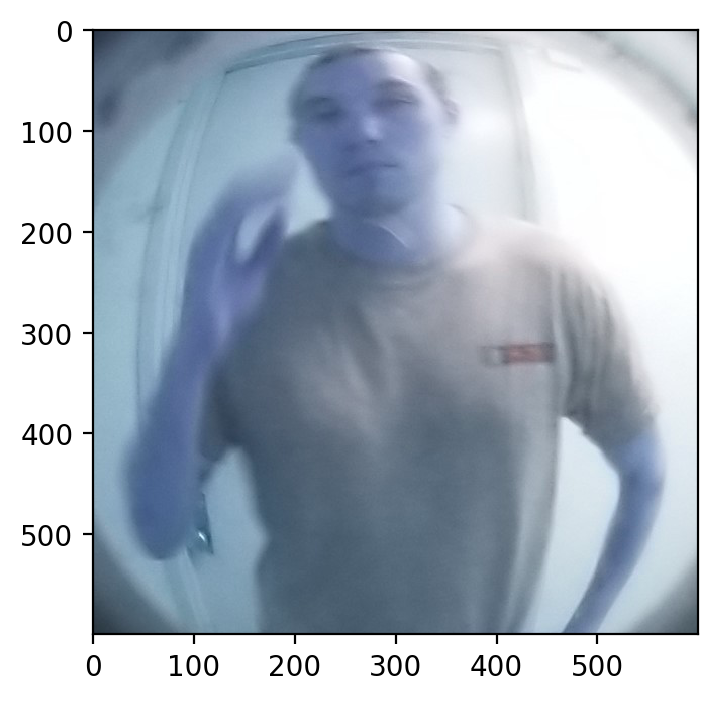

In [266]:
undistorted = undistort(ENVIRONMENT_NAME + '/' + DATA_FOLDER_NAME + '/test/corbet4.jpg', K, D)
img = cv2.imread(ENVIRONMENT_NAME + '/' + DATA_FOLDER_NAME + '/test/corbet4.jpg')
img = resize_img(img, (600, 600))
fig, ax = plt.subplots(dpi=200)
ax.imshow(img)

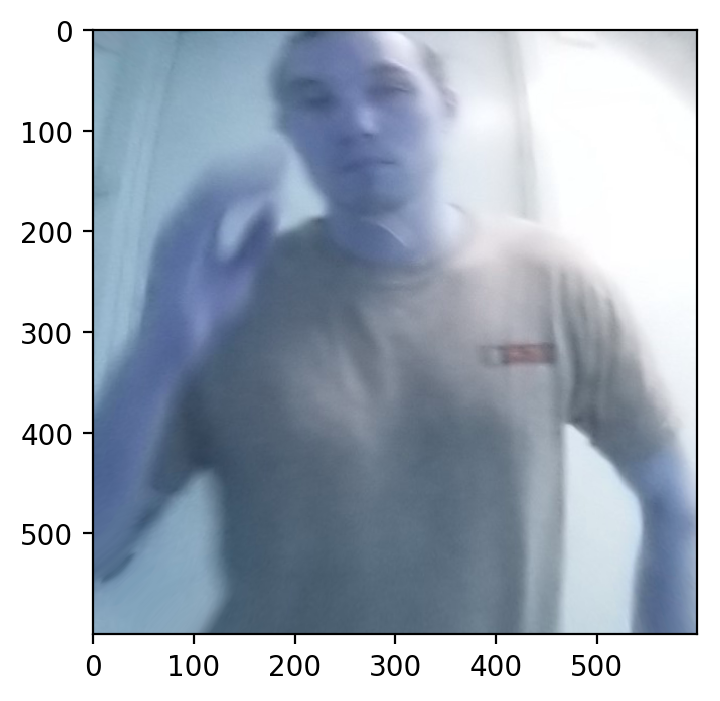

In [273]:
fig, ax = plt.subplots(dpi=200)
ax.imshow(resize_img(undistorted, (600,600)))

In [274]:
# img = fr.load_image_file(ENVIRONMENT_NAME + '/data/test/max.jpg')
resized_img, bounding_box = robust_bounding_boxes(resize_img(img, (600, 600)), 'cnn')
encoding = fr.face_encodings(resized_img, known_face_locations=[bounding_box], num_jitters=1)[0]
knn.predict([encoding])

	 (599, 600, 3)
	 0 0


c:\users\the-slick\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


array(['drew'], dtype=object)

In [ ]:
img = fr.load_image_file(ENVIRONMENT_NAME + '/data/test/arsh.jpg')
resized_img, bounding_box = robust_bounding_boxes(img)
encoding = fr.face_encodings(resized_img, known_face_locations=[bounding_box], num_jitters=1)[0]
knn.predict([encoding])

In [ ]:
img = fr.load_image_file(ENVIRONMENT_NAME + '/data/test/caleb.jpg')
resized_img, bounding_box = robust_bounding_boxes(img)
encoding = fr.face_encodings(resized_img, known_face_locations=[bounding_box], num_jitters=1)[0]
knn.predict([encoding])

In [ ]:
img = fr.load_image_file(ENVIRONMENT_NAME + '/data/test/drew.jpg')
resized_img, bounding_box = robust_bounding_boxes(img)
encoding = fr.face_encodings(resized_img, known_face_locations=[bounding_box], num_jitters=1)[0]
knn.predict([encoding])